In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
!pip install torchsummary
from torchsummary import summary
pd.set_option('display.max_columns', None)



import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils ,models
from PIL import Image
from torch import optim


import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
df = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")

In [3]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [4]:
important_feature=df[['image_id','Male','Young']].copy()

In [5]:
del df

In [6]:
important_feature.replace(-1,0,inplace=True)

In [7]:
important_feature.shape

(202599, 3)

In [8]:
#splitting train , validation .test

In [9]:
train = important_feature.iloc[:50016] 
val = important_feature.iloc[50017:60033] 
test = important_feature.iloc[60034:65034]


In [10]:
print("length of train data ", len(train))
print("length of validataion data ", len(val))
print("length of test data ", len(test))


length of train data  50016
length of validataion data  10016
length of test data  5000


In [25]:
#creating dataset

In [12]:
class CreateDataset(Dataset):
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.5,0.5,0.5],
                                     std=[0.5,0.5,0.5])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name , male , young = self.data.iloc[idx]
        img_loc = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'+str(image_name)

        img = Image.open(img_loc)
        img = self.normalize(self.to_tensor(self.scaler(img)))
        
        
        

        return image_name, img , torch.tensor([male , young],dtype=torch.float)

In [13]:
# loading data
train_Dataset = CreateDataset(train)
batch_size=32
train_Dataloader = DataLoader(train_Dataset, batch_size = batch_size, shuffle=True)


val_Dataset = CreateDataset(val)
val_Dataloader = DataLoader(val_Dataset, batch_size = batch_size, shuffle=True)


test_Dataset = CreateDataset(test)
test_Dataloader = DataLoader(test_Dataset, batch_size = 1, shuffle=False)

In [14]:
#defining cnn models

In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224



    return model_ft, input_size




In [17]:
def accuracy(output,target,batch_size):
    output=output.cpu().numpy()
    target=target.cpu().numpy()
    output=output>0
    output.astype(float)
    return np.sum(output==target)/(batch_size*2)

In [18]:
#function that train a given model
import time
def train(model):
    params_to_update=[]
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
#             print("\t",name)
            
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(params_to_update, lr=0.003)
    model.to(device)
    
    
    
    EPOCH=10
    loss_value_train=[]
    loss_value_val=[]
    eval_accuracy=[]
    min_val_loss=float('inf')
    max_acc=0
    for epoch in range(EPOCH):
        running_loss=0
        epoch_train_loss = []
        ### Train Loop
        model.train()
        t0 = time.time()
        t1 = time.time()
        print("Training ... ")
        for i ,data in enumerate(train_Dataloader):
            image_name, img ,target = data

            optimizer.zero_grad()

            img = img.to(device)

            target = target.to(device)


            output = model.forward(img)
            loss = criterion(output,target)

            running_loss += loss.item()
            epoch_train_loss.append(loss.item())

            loss.backward()
            optimizer.step()


            # print statistics
#             if i % 100 == 99:    # print every 2000 mini-batches
#                 print(f"[{epoch + 1,i + 1}] loss : {round(running_loss / 100, 3)} time : {round(time.time() - t1,2)} sec")
#     #             print('[%d, %5d] loss: %.3f time : %' %
#     #                   (epoch + 1, i + 1, running_loss / 20),time.time() - t1)
#                 t1 = time.time()
#                 running_loss = 0.0

        print("Epoch -> ", epoch," Training Loss -> ",
              round(sum(epoch_train_loss)/len(train_Dataloader),3),f' time : {round(time.time() - t0,2)} sec')

        loss_value_train.append(sum(epoch_train_loss)/len(train_Dataloader))

        ### Eval Loop

        print("Evaluating...")


        model.eval()


        with torch.no_grad():
            running_loss=0
            epoch_val_loss=[]
            running_accuracy=0


            for i ,data in enumerate(val_Dataloader):


                image_name, img ,target = data

                optimizer.zero_grad()

                img = img.to(device)

                target = target.to(device)


                output = model.forward(img)
                loss = criterion(output,target)

                running_loss += loss.item()
                epoch_val_loss.append(loss.item())
                running_accuracy += accuracy(output,target,batch_size)

        total_val_loss=round(sum(epoch_val_loss)/len(val_Dataloader),3)
        acc=round(running_accuracy/len(val_Dataloader),3)
        print(" Evaluate Loss -> ",
              total_val_loss," Accuracy --> ",acc)

        loss_value_val.append(sum(epoch_val_loss)/len(val_Dataloader))
        eval_accuracy.append(acc)
        
        if acc> max_acc:
            max_acc=acc
            
    return eval_accuracy,max_acc






In [19]:
print("Downloading Models")
model_name=['resnet','alexnet','vgg','squeezenet', 'densenet']
for i in model_name:
    model_ft, input_size = initialize_model(i, num_classes=2, feature_extract=True, use_pretrained=True)
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


  0%|          | 0.00/4.79M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cuda


In [21]:
torch.manual_seed(42)

model_name=['resnet','alexnet','vgg','squeezenet', 'densenet']
eval_accuracy=[]
max_acc=[]
model_stats={}
for i in model_name:
    
    print(f"Training {i}")
    
    model_ft, input_size = initialize_model(i, num_classes=2, feature_extract=True, use_pretrained=True)
    
    eval_accuracy,max_acc=train(model_ft)
    model_stats[i]=eval_accuracy
    print()
#     print(model_stats)

Training resnet
Training ... 
Epoch ->  0  Training Loss ->  0.312  time : 507.32 sec
Evaluating...
 Evaluate Loss ->  0.29  Accuracy -->  0.874
Training ... 
Epoch ->  1  Training Loss ->  0.297  time : 292.04 sec
Evaluating...
 Evaluate Loss ->  0.332  Accuracy -->  0.866
Training ... 
Epoch ->  2  Training Loss ->  0.29  time : 289.06 sec
Evaluating...
 Evaluate Loss ->  0.255  Accuracy -->  0.892
Training ... 
Epoch ->  3  Training Loss ->  0.283  time : 288.2 sec
Evaluating...
 Evaluate Loss ->  0.278  Accuracy -->  0.888
Training ... 
Epoch ->  4  Training Loss ->  0.281  time : 287.43 sec
Evaluating...
 Evaluate Loss ->  0.262  Accuracy -->  0.886
Training ... 
Epoch ->  5  Training Loss ->  0.275  time : 283.65 sec
Evaluating...
 Evaluate Loss ->  0.245  Accuracy -->  0.899
Training ... 
Epoch ->  6  Training Loss ->  0.275  time : 284.65 sec
Evaluating...
 Evaluate Loss ->  0.252  Accuracy -->  0.892
Training ... 
Epoch ->  7  Training Loss ->  0.274  time : 284.99 sec
Evaluat

In [22]:
model_stats_df=pd.DataFrame(model_stats)

In [28]:
model_stats_df.head()

,resnet,alexnet,vgg,squeezenet,densenet
0,0.874,0.837,0.876,0.783,0.889
1,0.866,0.849,0.869,0.792,0.893
2,0.892,0.843,0.877,0.802,0.889
3,0.888,0.855,0.882,0.812,0.887
4,0.886,0.852,0.874,0.817,0.888


In [29]:
import seaborn as sns

<AxesSubplot:>

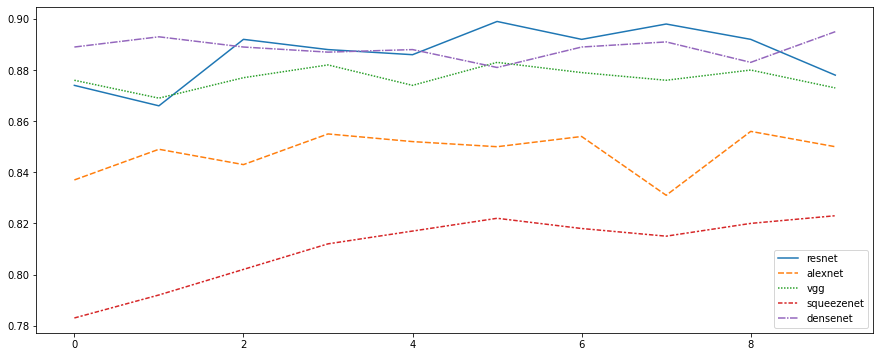

In [34]:
plt.figure(figsize=(15,6 ))
sns.lineplot(data=model_stats_df)

In [24]:
# As seen from graph the models Resnet and Densenet perform equally
# We choose Resnet as it has less parameters than Densenet hence consume less memory and will be faster when hosted